# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용
사전에 학습된 모바일 넷 모델을 사용

## STEP #1: IMPORT LIBRARIES

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import sys

# 버전 downgrade

In [ ]:
!pip install tensorflow==2.13.0
!pip install tensorflow_hub==0.14.0

## STEP #2: Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

- Fine Tuning 없이 사용하기 위해 Full Model download
--> fine tuning 안한게 베스트임. 그냥 만들어진 모델을 그대로 사용하는거니깐

In [ ]:
Trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

# () 안에 리스트로도 넣을 수 있음, 리스트 안에 layer를 추가할 수 있음 이 방법을 선호
Trained_Mobilenet = tf.keras.Sequential([
        # 사전 훈련된 url을 주면 kerasLayer에 이 모델이 들어간다
        # input_shape = (244,244,3) 애초에 모바일넷이 훈련될때 224 x 224 사이즈임
        # 해당 칼라 이미지 입력 사양에 맞게 입력해줘야한다.
        hub.KerasLayer(Trained_MobileNet_url, input_shape = (224,224,3))])

Trained_Mobilenet.input, Trained_Mobilenet.output


(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

# STEP #3: PRE-TRAINED MOBILENET 평가

임의의 사진을 internet에서 가져온다

In [ ]:
from PIL import Image # 파이썬에서는 이미지 처리하는 라이브러리를 PIL라고 한다.
from urllib import request # 웹브라우저에서 이미지 데이터를 가지고 옴

# 아스키 코드를 읽어서 다시 이미지 형태로 바꾸는 함수
from io import BytesIO # 인터넷에서 돌아다니는 이미지는 픽셀 숫자로 안되어 있고 바이트 코드,아스키 코드로 바껴서 옴
# 임의의 인터넷 url 사진
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"
res = request.urlopen(url).read() # url을 open해서 바이트 코드로 보여짐
res


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe1\x00\x16Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xdb\x00C\x01\x03\x03\x03\x04\x03\x04\x08\x04\x04\x08\x10\x0b\t\x0b\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\xff\xc0\x00\x11\x08\x02~\x03\xc0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x04\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\x05\x06\x07\x08\t\n\xff\xc4\x00T\x10\x00\x01\x03\x02\x05\x02\x04\x04\x03\x04\x07\x05\x05\x06\x01\r\x01\x02\x03\x11\x00\x04\x05\x06\x12!1\x07A\x13"Qa\x08\x14q\x812\x91\x

바이트 코드로 이뤄진 res를 이미지 형태로 변환

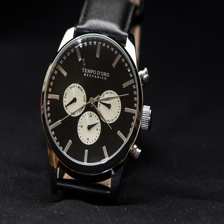

In [ ]:
Sample_Image = Image.open(BytesIO(res)).resize((224,224)) # 인터넷에서 가지고 온 사이즈는 다르니깐 224,224로 바꿔준다.
Sample_Image

In [ ]:
x = tf.keras.applications.mobilenet.preprocess_input(np.array(Sample_Image)) # 샘플 이미지를 array로 바꿔서 입력해준다
x
# 샘플 이미지가 224,224로 resize되어 있는데 이걸 np.array로 바꿔서 preprocess_input라고 하는 메소드의 입력으로 주면 preprocessed된 이미지 데이터가 출력이 된다
# 처음에 모바일넷으로 훈련할 때 이미지 크기는 224x224로 받았고 픽셀이 0~255 사이인데 이걸 심플 스케일링을 했는데 Standard 스케일링을 했는지 모름
# 전처리를 똑같이 해줘야하기 때문에 모델을 어떻게 전처리했는지 알아야함 --> 그래서 만든 함수가 preprocess_input
# 이 함수를 사용하면 모바일넷과 동일하게 전처리가 됨

array([[[-0.9843137 , -0.9843137 , -0.9843137 ],
        [-0.9843137 , -0.9843137 , -0.9843137 ],
        [-0.9843137 , -0.9843137 , -0.9843137 ],
        ...,
        [-0.94509804, -0.94509804, -0.92941177],
        [-0.94509804, -0.94509804, -0.92941177],
        [-0.94509804, -0.94509804, -0.92941177]],

       [[-0.9843137 , -0.9843137 , -0.9843137 ],
        [-0.9843137 , -0.9843137 , -0.9843137 ],
        [-0.9843137 , -0.9843137 , -0.9843137 ],
        ...,
        [-0.94509804, -0.94509804, -0.92941177],
        [-0.94509804, -0.94509804, -0.92941177],
        [-0.94509804, -0.94509804, -0.92941177]],

       [[-0.9843137 , -0.9843137 , -0.9843137 ],
        [-0.9843137 , -0.9843137 , -0.9843137 ],
        [-0.9843137 , -0.9843137 , -0.9843137 ],
        ...,
        [-0.94509804, -0.94509804, -0.92941177],
        [-0.94509804, -0.94509804, -0.92941177],
        [-0.94509804, -0.94509804, -0.92941177]],

       ...,

       [[-0.6784314 , -0.6784314 , -0.6627451 ],
        [-0

In [ ]:
x.shape

(224, 224, 3)

(224,224,3)을 그대로 넣어주면 차원이 안 맞기 때문에 np.expand_dims을 사용해준다. 첫번째 축에 차원을 추가해준다(axis = 0)
- 원래 MobileNet 모델은 batch 데이터를 입력으로 받아서 훈련되었기 때문에 우리는 지금 딱 하나의 이미지만 주지만 이게  batch인 것 처럼 --> 이미지 하나로 이뤄진 batch 형태로 (1,224,224,3)으로 차원 증가를 해준다.

In [ ]:
predicted_class = Trained_Mobilenet.predict(np.expand_dims(x, axis = 0))
predicted_class # 확률분포가 출력된다

1/1 [==============================] - 1s 850ms/step


array([[ 0.23864844,  1.5282722 , -0.5359737 , ..., -0.03730475,
        -1.3960836 ,  1.0369139 ]], dtype=float32)

In [ ]:
predicted_class.shape # 1001가지의 확률분포
# 원래 1000개의 클래스를 분류하는 모델인데 첫번째는 배경임. 그래서 배경 포함해서 1001개

(1, 1001)

In [ ]:
predicted_class.argmax(axis = 1)
# 827번째에 있는 확률이 가장 큰 값을 보임

array([827])

array([827])이 뭔지 모르니깐 decode_predictions을 사용해서 다시 디코딩을 해준다.

In [ ]:
decode_predictions(predicted_class[:,1:]) # 첫번째는 배경이니깐 제외 [:,1:]
# stopwatch일 확률이 9.6%
# analog_clock일 확률이 8.4% ,,, top5를 출력했음

35363/35363 [==============================] - 0s 0us/step


[[('n04328186', 'stopwatch', 9.666365),
  ('n02708093', 'analog_clock', 8.007808),
  ('n03706229', 'magnetic_compass', 6.8384595),
  ('n04548280', 'wall_clock', 6.563989),
  ('n03197337', 'digital_watch', 4.9182067)]]

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# keras.utils.get_file 함수에 url 주소를 주면 txt 파일에 있는 1000가지 이미지가 뭔지 알 수 있다.
imagenet_labels =  open(labels_path).read().splitlines()

imagenet_labels[827] # 가장 확률 분포가 크게 나온 것이 stopwatch라고 알 수 있다.

10484/10484 [==============================] - 0s 0us/step


'stopwatch'

In [ ]:
imagenet_labels[1:20] # Imagenet에 있는 1000가지의 레이블 중 한 20개만 살펴보자
# 첫번째는 그냥 배경, background이기 때문에 제외하고 [1:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie']

**지금까진 fine tuning을 안하고 기존 모델만 살펴봤음**

## STEP #4: 특정 domain 의 Batch Image 에 대한 MobileNet 평가 - No Fine Tuning

### MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것 예상

tf.keras.utils.get_file은 인터넷 상에 있는 파일의 위치 url을 지정해주면 그 이미지를 가지고옴

In [ ]:
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True) # untar = True를 해주면 압축까지 해제 해서 flower_photos라고 하는 폴더에 저장함

228813984/228813984 [==============================] - 3s 0us/step


In [ ]:
flowers_data_path

'/root/.keras/datasets/flower_photos'

- flower data 는 5 개의 class 로 구성

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # 외부에서 이미지를 가지고 왔을 때 mobilenet에 맞는 전처리 방식으로 전처리 해야함 --> preprocess_input
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input # 전처리 모듈
)
# flowers_data에 저장된 데이터를 flow_from_directory로 부터 읽어들임
# 224,224로 이미지 사이즈를 맞춰주고 batch_size를 64로 설정 & 데이터를 섞어라
flower_data = image_generator.flow_from_directory(
    flowers_data_path, target_size = (224,224), batch_size = 64, shuffle = True
)


Found 3670 images belonging to 5 classes.


* generator랑 함수의 차이

In [ ]:
# 파이썬에서 말하는 일반적인 함수
#def xx():
#  return result

# generator : 다음번 요청을 기다리고 있음. 끝나는 게 아니라
# --> generator에서 데이터를 가지고 오는 것을 파이썬은 next()로 데이터를 가지고
#def xx():
#  yield result # return이 yield로 바뀜

In [ ]:
# flow_from_directory는 데이터하고 데이터가 있는 폴더 이름을 target으로 가지고 옴
# input_batch = 이미지 자체, label_batch = 이미지가 존재하는 폴더 이름
input_batch, label_batch = next(flower_data)
input_batch.shape, label_batch.shape # 5개의 클래스이기 때문에 (64,5)

((64, 224, 224, 3), (64, 5))

In [ ]:
label_batch[0] # 원-핫 인코딩이 되어 있는 상태

array([0., 0., 0., 1., 0.], dtype=float32)

flower class 숫자

In [ ]:
flower_data.num_classes

5

flower class label 확인

In [ ]:
flower_data.class_indices # 클래스 번호랑 실제 클래스 이름이랑 매칭할 수 있다

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

flower_data.class_indices를 딕셔너리 형태로 바꿔주기 --> key, value 순서를 바꿔주기
- .items()을 해주면 key : value 쌍으로 반환한다.
- 이 형태가 더 많이 사용됨

In [ ]:
class_names = {v:k for k,v in flower_data.class_indices.items()}
class_names


{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 10 개 image 시각화

In [ ]:
input_batch[0].min(), input_batch[0].max() # 현재는 스케일링이 된 사이
# 다시 0~255으로 RGB 값을 바꿔줘야

(-1.0, 1.0)

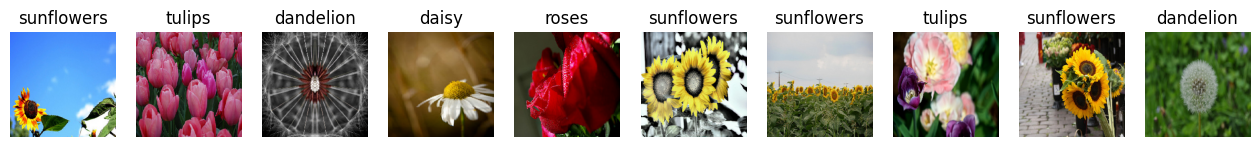

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,8))

for i in range(10):
  plt.subplot(1,10,i+1)

  # 사진 복원
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)# 0~255 사이로 값이 바뀜 & int타입으로 바꿔줌

  # 어떤 사진인지 title 설정해주기
  idx = np.argmax(label_batch[i]) # label_batch가 input_batch에 매칭되는 레이블
  plt.title(class_names[idx]) # idx는 몇 번째인지, 인덱스 값임 [idx]로 입력해줘야함

  plt.imshow(img)
  plt.axis("off") # 축을 없애는 코드
  # warning : 현재 0~1 값으로 데이터가 이뤄져 있음 --> 0~255 사이값으로 되어야 이미지가 제대로 나옴
  # preprocess_input으로 이미지를 전처리해놔서 이미지가 원래랑 다름


- 임의의 꽃 image 1 개를 선택하여 prediction 비교

In [ ]:
prediction = Trained_Mobilenet.predict(input_batch[2:3]) # 위 그림에서 dandelion을 예측해봤음
decode_predictions(prediction[:, 1:]) # 예측 결과 sear_urchin이 가장 높게 나옴
# sea_urchin, spider_web, barn_spider, peacock, tarantula 이렇게 예측이 되었음
# ImageNet에서 훈련시킨 1000가지 레이블 중에 구체적인 꽃 레이블이 없는거임 --> 우리한테 적합한 모델로 다시 학습하

1/1 [==============================] - 0s 65ms/step


[[('n04275548', 'spider_web', 6.5462894),
  ('n04192698', 'shield', 5.81955),
  ('n03388043', 'fountain', 5.6460614),
  ('n02782093', 'balloon', 4.887098),
  ('n03065424', 'coil', 4.5858293)]]

# STEP #5: 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain

### Fine Tuning 을 위해 head 가 제거된 model 을 download  
--> output layer 를 top layer라고, 이 top layer를 제거한 모델을 다운받기

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [ ]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [ ]:
extractor_layer = hub.KerasLayer(extractor_url, input_shape = (224,224,3))
extractor_layer(input_batch).shape

TensorShape([64, 1280])

- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [ ]:
extractor_layer.trainable = False # 더 이상 훈련이 일어나지 X 기존에 훈련된 것을 유지

In [ ]:
model = tf.keras.Sequential([
        extractor_layer,
        tf.keras.layers.Dense(5, activation = "softmax")

])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
model.input ,model.output #input size = (224,224,3), output은 5개의 클래스를 분류

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

In [ ]:
prediction = model(input_batch)
prediction.shape # 훈련 안된 모델에 input_batch를 넣어보기
# ([64,5]) : 64개의 이미지에 대해서 5개의 확률 분포가 잘 나오고 있음

TensorShape([64, 5])

- output shape 이 정확한지 training 전에 사전 check

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

# flower 전용 모델 학습

In [ ]:
history = model.fit(flower_data, epochs = 30)

Epoch 1/30
58/58 [==============================] - 130s 2s/step - loss: 0.9483 - accuracy: 0.6371
Epoch 2/30
58/58 [==============================] - 118s 2s/step - loss: 0.4773 - accuracy: 0.8341
Epoch 3/30
58/58 [==============================] - 120s 2s/step - loss: 0.3935 - accuracy: 0.8687
Epoch 4/30
58/58 [==============================] - 116s 2s/step - loss: 0.3369 - accuracy: 0.8894
Epoch 5/30
58/58 [==============================] - 115s 2s/step - loss: 0.3048 - accuracy: 0.8943
Epoch 6/30
58/58 [==============================] - 115s 2s/step - loss: 0.2758 - accuracy: 0.9112
Epoch 7/30
58/58 [==============================] - 115s 2s/step - loss: 0.2522 - accuracy: 0.9169
Epoch 8/30
58/58 [==============================] - 116s 2s/step - loss: 0.2356 - accuracy: 0.9253
Epoch 9/30
58/58 [==============================] - 111s 2s/step - loss: 0.2240 - accuracy: 0.9275
Epoch 10/30
58/58 [==============================] - 112s 2s/step - loss: 0.2091 - accuracy: 0.9338
Epoch 11/

# STEP #6: Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

# 예측

In [ ]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis = -1)
y_pred

2/2 [==============================] - 2s 623ms/step


array([3, 4, 1, 0, 2, 3, 3, 4, 3, 1, 1, 1, 1, 3, 1, 0, 2, 0, 2, 4, 1, 1,
       4, 3, 0, 1, 4, 3, 4, 0, 4, 2, 1, 4, 2, 0, 2, 1, 1, 4, 4, 1, 4, 3,
       0, 2, 4, 1, 2, 3, 1, 4, 1, 1, 1, 0, 1, 3, 2, 4, 4, 3, 4, 2])

In [ ]:
y_true = np.argmax(label_batch, axis = -1)
y_true

array([3, 4, 1, 0, 2, 3, 3, 4, 3, 1, 1, 1, 1, 3, 1, 0, 2, 0, 2, 4, 1, 1,
       4, 3, 0, 1, 4, 3, 4, 0, 4, 2, 1, 4, 2, 0, 2, 1, 1, 4, 4, 1, 4, 3,
       0, 2, 4, 1, 2, 3, 1, 4, 0, 1, 1, 0, 1, 3, 2, 4, 4, 3, 4, 2])

# 정확도 평가

In [ ]:
sum(y_pred == y_true) / len(y_true)
# 우리 모델은 5가지 flower에 대해서 100% 잘 분류하는 모델

0.984375